## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
# Special directive to Jupiter Notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from skimage.io import imread, imshow
## For metrics on ML performance
from sklearn.metrics import confusion_matrix

## Import related to splitting disease labels
from itertools import chain
from random import sample 
import scipy

## Train_test_split package comes from a sklearn package: 
import sklearn.model_selection as skl

## Image pre-processing import and backend libraries plus Keras API
import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
# from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, Adagrad, Adadelta
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

## Performance analysis
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import StratifiedKFold


# Visualize training history
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, AveragePooling2D, MaxPool2D, SeparableConv2D, BatchNormalization

# Import for plots
from sklearn.metrics import fbeta_score, roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from sklearn.preprocessing import binarize

# Neccessary for confusion matrix
import sklearn.metrics


Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

### What this code snippet below do
Line 1 reads the dataset into a dataframe.

For line 2, glob(os.path.join('/data','images*', '*', '*.png')) goes through our directory, /data and combine subdirectories starting with 'images' keyword, everything else also in the images subdirectory, and also everything ending with .png.

After gathering a list of these directories paths, we loop over all these directory paths and map each of them to an index in a dictionary containing index and image path.

In line 3, we then print the length and the shape of the headers.

In line 4, we go ahead and map our `Image Index` with the directory paths dictionary which we have collected.

From there we display a sample of 3 of our dataframe in line 5.

### Notes Map function
The map() function applies a given function to each item of an iterable and returns a list of the results. The map() function in Python takes in a function and a list.

The returned value from map() (map object) can then be passed to functions like list() (to create a list), set() (to create a set) and so on.

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
# x represent image index
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
# Create a column path and populate it by mapping panda series index to thier image path
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# Random sample of 3 images
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
64855,00016011_007.png,Consolidation|Effusion|Pneumonia,7,16011,27,F,AP,2048,2500,0.168,0.168,NaN,/data/images_007/images/00016011_007.png
18610,00004931_014.png,No Finding,14,4931,22,F,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00004931_014.png
24728,00006498_001.png,No Finding,1,6498,28,M,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00006498_001.png


### The distributions of variables as they relate to diseases
Let's try splitting up the 'Finding Labels' column into one additional column per disease (e.g. one for 'Cardiomegaly', one for 'Emphysema', etc.) and put a binary flag in that column to indicate the presence of the disease¶

### Note
In AI, **labels** are the things we are trying to predict. 
All of the possible label names are called your **classes**

 Here you may want to create some extra columns in your table with binary indicators of certain diseases 
rather than working directly with the 'Finding Labels' column

### Helper comments
Here we are trying to split each row on the Finding Labels column of the dataframe, data.
So thus, an iterable is generated with chain which maps/gets each row of the Finding label column and split it using the '|' character as separable. 
Which is then converted to a list i.e. Consolidation|Infiltration becomes ['Consolidation', 'Infiltration'] and No Finding becomes ['No Finding']
We then convert all the combination of these iterables into an actual list data structure with list.
Now we have a list of diseases, but most of them are duplicated since we didn't consider duplicates when creating the iterables. 
We now use np.unique which converts the list to an ndarray with unique values.
We now convert these labels into an actual list and filter all labels which their length is greater than zero. This is to avoid empty labels. 


In [4]:
# Todo
# Note that in AI, labels arethe things that we are trying to predict
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0] # Removes empty labels
# We now get a full list of all labels:
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

# So now we loop through each label and check if label is not empty, then create a column for that label and mapping all the values associated with that label.
# For each row of the Finding Labels column, we check if the label string exist in that column and assign it a 1 and a 0 otherwise. 
# i.e. we use the in operator to do the substring search.
for c_label in all_labels:
    if len(c_label)>1: # This leaves out empty labels
        # Create a new columns with c_label
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)


all_xray_df.sample(3)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
93127,00023271_019.png,No Finding,19,23271,40,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74602,00018315_000.png,No Finding,0,18315,57,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100111,00026535_000.png,No Finding,0,26535,26,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0



There are 15 unique types of labels found in my dataset

In [5]:
# Relative distribution of all unique labels
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

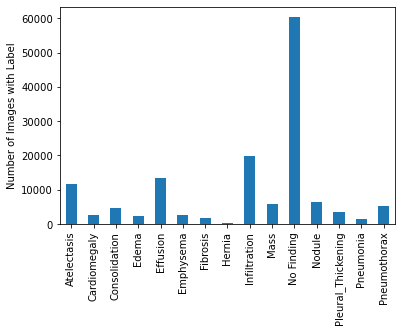

In [6]:
# Disease distribution
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Above, is the relative frequencies of each disease in my dataset. 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 53.8% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'


## The Lambda function
Syntax of Lambda Function in python - 
```
lambda arguments: expression
```

Lambda functions can have any number of arguments but only one expression. The expression is evaluated and returned. Lambda functions can be used wherever function objects are required.

Lambda functions are a form of writing shorter functions in code.
pandas.apply takes a function and applies it to all values in the pandas series.
In this case the function is a lambda function written in another form as below

```
def lambda(row):
 classifier(row['Pneumonia']) # The expression to be evaluated
 return result # The result atfer evaluation of the expression
```
Lastly axis=1 represents columns which in this case creates a column called pneumonia_class.
So the overall function of the code above creates a column and for every record(row) that has the Pneumonia as one of the diagnosed disease, a 1 is put as the record value for that column(Pneumonia_class) and when otherwise a 0 is put there.

In [7]:
#Create a method that takes in a variable label and returns a str(label) or str(Not Label).
def pneumonia_class(Pneumonia):
    if Pneumonia > 0:
        return 'Pneumonia'
    else:
        return 'Not Pneumonia'
# Create a new column pneumonia_class and populate it with a Label or Not Label
# The values for the column pneumonia_class should be of string datatype
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda row: pneumonia_class(row['Pneumonia']), axis=1)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
40394,00010524_001.png,Edema|Infiltration|Pneumonia,1,10524,63,F,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
50005,00012655_000.png,Infiltration,0,12655,54,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia
46709,00011925_034.png,Effusion|Infiltration,34,11925,54,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia


### Renaming
The first function we'll introduce here is rename(), which lets you change index names and/or column names. For example, to change the points column in our dataset to score, we would do:

rename() lets you rename index or column values by specifying a index or column keyword parameter, respectively. It supports a variety of input formats, but usually a Python dictionary is the most convenient.

The two examples as ther are used:
First with columns:
renamed = reviews.rename(columns={'points': 'score'})
Next with index which is not often used
reviews.rename(index={0: 'firstEntry', 1: 'secondEntry'})

To rename index, it preferable to use  rename_index:
Set the index name in the dataset to wines.
reindexed = reviews.rename_axis("wines", axis='rows')

## Create your training and testing data:

In [8]:
def create_splits(df, stratify):
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   # Dictionary key code for a series: find & partition with label
                                   stratify = stratify)
    
    return train_data, val_data

In [9]:
train_data, val_data = create_splits(all_xray_df, stratify=all_xray_df['pneumonia_class'])


### Sizes of training and test data after split

In [10]:
print('Total data size: {}'.format(len(all_xray_df)))
print('Pneumonia training data size: {}'.format(len(train_data)))
print('Pneumonia validation data size: {}'.format(len(val_data)))

Total data size: 112120
Pneumonia training data size: 89696
Pneumonia validation data size: 22424


AxesSubplot(0.125,0.125;0.775x0.755)


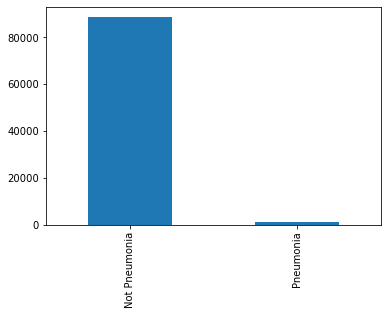

In [11]:
# Used to debug the bar chat x and y axis.
print(train_data.pneumonia_class.value_counts().plot(kind = 'bar'))


In [12]:
# This counts the values of number of occurences of a single column and this may be a column that indexes the rows
# in this case pneumonia class
train_data.pneumonia_class.value_counts()

Not Pneumonia    88551
Pneumonia         1145
Name: pneumonia_class, dtype: int64

In [13]:
# This converts the index of the counts to list for the x  axis
x = train_data.pneumonia_class.value_counts().index.to_list()
x

['Not Pneumonia', 'Pneumonia']

In [14]:
# This converts the values of the count to a list which is the height of the y axis
y = list(train_data.pneumonia_class.value_counts().values)
y

[88551, 1145]

In [15]:
# Print the data
train_data.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
85073,00020967_011.png,No Finding,11,20967,62,M,AP,2856,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Not Pneumonia
64290,00015857_000.png,No Finding,0,15857,56,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Not Pneumonia
5909,00001587_000.png,No Finding,0,1587,49,F,PA,2766,2885,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Not Pneumonia


### Bar chart showing proprotion of the training data and validation data

Text(0, 0.5, 'Size of validation data')

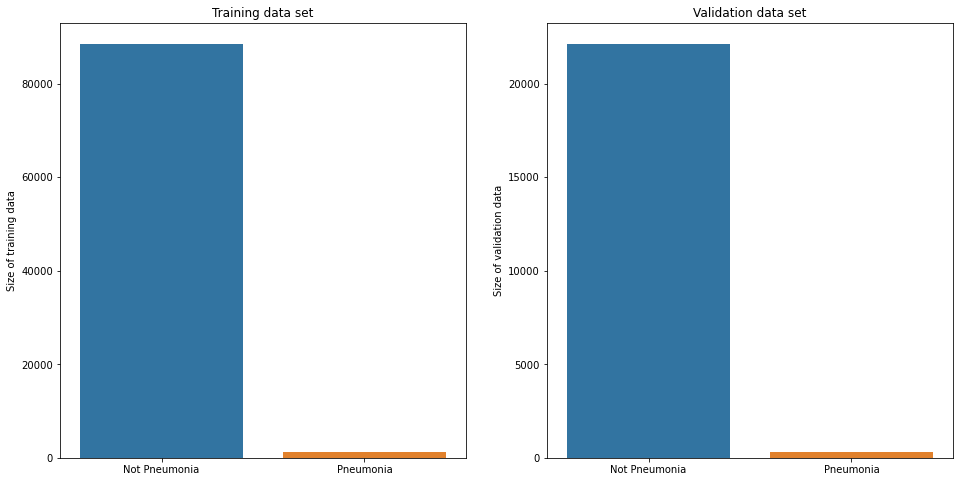

In [16]:
# Set the width and height of the figure
fig = plt.figure(figsize=(16,8))

# Add first figure
fig.add_subplot(1,2, 1)
# Add title
plt.title("Training data set")


# Bar chart showing distribution of training data by pneumonia_class

## On the horizontal axis, we have selected the column pneumonia class.

## The  y = train_data['pneumonia_class'] sets the column in the data that 
## will be used to determine the height of each bar. 
## In this case, we select the 'pneumonia_class' column.
sns.barplot(x=train_data.pneumonia_class.value_counts().index.to_list(), y=list(train_data.pneumonia_class.value_counts().values))


# Add label for vertical axis
plt.ylabel("Size of training data")
            

# Add second fugure
fig.add_subplot(1,2, 2)

# Add title
plt.title("Validation data set")

# Bar chart showing distribution of Pneumonia within the validation data
sns.barplot(x=val_data.pneumonia_class.value_counts().index.to_list(), y=list(val_data.pneumonia_class.value_counts().values)) 

# Add label for vertical axis
plt.ylabel("Size of validation data")
 


#### Rations of Pneumonia cases in each subset of data- Training and validation

In [17]:
# Ratio Pneumonia cases in the training subset of data stored in a variable td
td = train_data.pneumonia_class.value_counts().values/len(train_data)

In [18]:
# Ratio Pneumonia cases in the validation subset of data stored in a variable vd
vd = val_data.pneumonia_class.value_counts().values/len(val_data)

In [19]:
print('All Pneumonia Ratios: training({})  validation({})'.format(td, vd))


All Pneumonia Ratios: training([0.98723466 0.01276534])  validation([0.98724581 0.01275419])


Our train_test_split made sure that we had the same proportions of Pneumonia in both sets! But.... we know that we want our model to be trained on a set that has equal proportions of Pneumonia and no Pneumonia, so we're going to have to throw away some data:

Hint: you can random sample the negative cases to obtain a balanced training set.

In [20]:
# Discard excess data from the train data with these code snipetts
# p_inds are indexes of pnemonia data and np_inds are indexes of not pnuemonia data
p_inds = train_data[train_data.pneumonia_class=='Pneumonia'].index.tolist()
np_inds = train_data[train_data.pneumonia_class=='Not Pneumonia'].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's as big as the pneumonia sample.
np_sample = sample(np_inds,len(p_inds))
# Assignment of value to train_df
train_data = train_data.loc[p_inds + np_sample]

### Also remodel validation data 1:4
Validation set must contain 20:80 ratio (positive to negative) 

In [21]:
# We will discard some data from the validation set to ratio of 1:4
p_inds = val_data[val_data.pneumonia_class=='Pneumonia'].index.tolist()
np_inds = val_data[val_data.pneumonia_class=='Not Pneumonia'].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
# Assignment of value to val_df
val_data = val_data.loc[p_inds + np_sample]

### Sizes of train and validation data after discarding excess data
Bar chart showing the distribution of the training and validation data by pneumonia_class¶

In [22]:
# This counts the values of number of occurences of a single column and this may be a column that indexes the rows
# in this case pneumonia class
# This train_ data is the same variable after discarding excess data
train_data.pneumonia_class.value_counts()

Pneumonia        1145
Not Pneumonia    1145
Name: pneumonia_class, dtype: int64

Text(0, 0.5, 'Size of validation data')

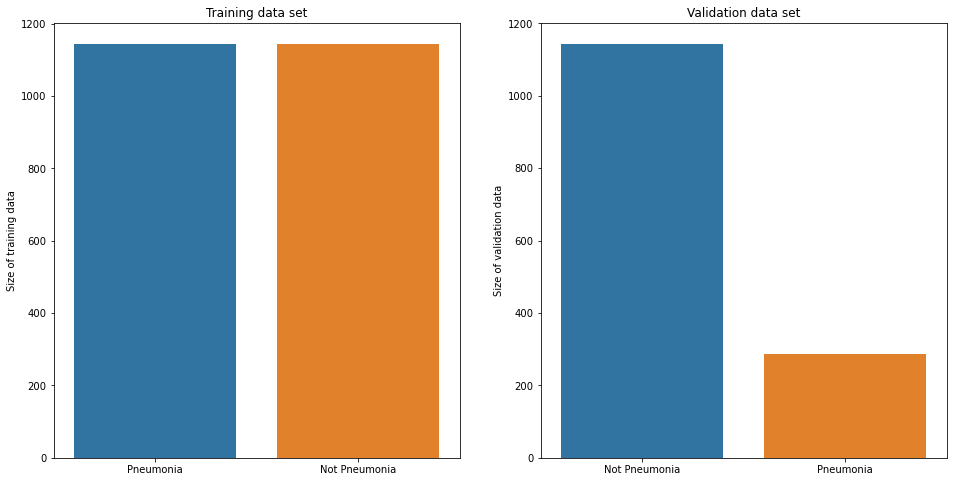

In [23]:
# Set the width and height of the figure
fig = plt.figure(figsize=(16,8))

# Add first figure
fig.add_subplot(1,2, 1)
# Add title
plt.title("Training data set")


# Bar chart showing distribution of training data by pneumonia_class

## On the horizontal axis, we have selected the column pneumonia class.

## The  y = train_data['pneumonia_class'] sets the column in the data that 
## will be used to determine the height of each bar. 
## In this case, we select the 'pneumonia_class' column.
sns.barplot(x=train_data.pneumonia_class.value_counts().index.to_list(), y=list(train_data.pneumonia_class.value_counts().values))


# Add label for vertical axis
plt.ylabel("Size of training data")
            

# Add second fugure
fig.add_subplot(1,2, 2)

# Add title
plt.title("Validation data set")

# Bar chart showing distribution of Pneumonia within the validation data
sns.barplot(x=val_data.pneumonia_class.value_counts().index.to_list(), y=list(val_data.pneumonia_class.value_counts().values)) 

# Add label for vertical axis
plt.ylabel("Size of validation data")
 

 


#### Rations of Pneumonia cases in each subset of data- Training and validation after discarding excess data


In [24]:
# Training data ratio post randomisation
td = train_data.pneumonia_class.value_counts()/len(train_data)

In [25]:
# Validation data post ra ratio
vd = val_data.pneumonia_class.value_counts()/len(val_data)

In [26]:
print('All Pneumonia Ratios: training({})  validation({}'.format(td, vd))

All Pneumonia Ratios: training(Pneumonia        0.5
Not Pneumonia    0.5
Name: pneumonia_class, dtype: float64)  validation(Not Pneumonia    0.8
Pneumonia        0.2
Name: pneumonia_class, dtype: float64



# Now we can begin our model-building & training

### First, let's look at what our plane images look like

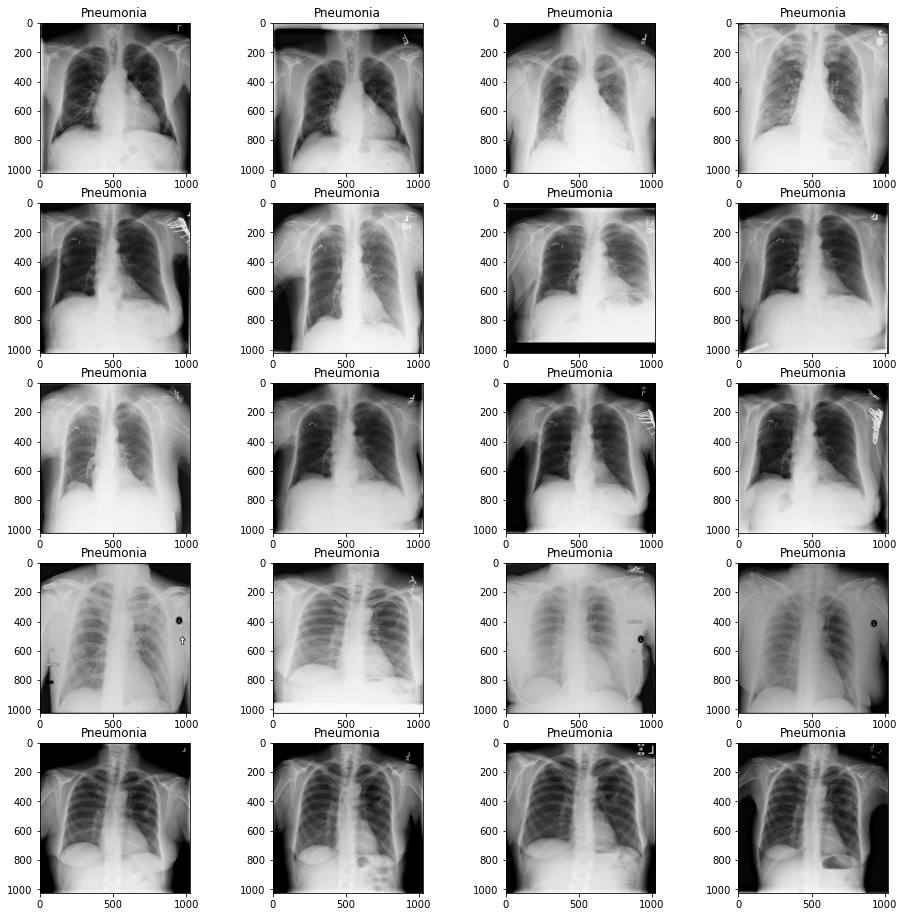

In [27]:
# Create a figure with subplots and has a maximum axis: m-axis
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
# Return a copy of the array collapsed into one dimension.
m_axs = m_axs.flatten()
imgs = all_xray_df.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(train_data.iloc[ind]['pneumonia_class'])
    ind=ind+1

In [28]:
## you can choose an image size to resize your images to during augmentation, which comes in handy later when you
## want to do deep learning using a pre-trained CNN that has a specified size input layer
IMG_SIZE = (224, 224)

### Perform image standardization

#### First suggestion: perform some image augmentation on your data

Play around with different values for the parameters, running the visualization cell below each time to see how these parameters change the appearance of your augmented data. Make some conclusions about what sorts of values might or might not be appropriate for medical imaging based on what you might see in the real world. You can look at the ImageDataGenerator documentation in Keras to add other parameters as well.
```
horizontal_flip and vertical_flip should be set to True/False
height_shift_range and width_shift_range should be between 0 and 1
rotation_range can be between 0 and 180
shear_range can be between 0 and 1
zoom_range can be between 0 and 1
```

In [29]:
## Normalize and Augment data
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                      horizontal_flip = True, 
                      vertical_flip = False, 
                      height_shift_range= 0.1, 
                      width_shift_range=0.1, 
                      rotation_range=20, 
                      shear_range = 0.1,
                      zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                 directory=None, 
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE, 
                                 batch_size = 16)


## Only normalize data 
# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
val_idg = ImageDataGenerator(rescale=1. / 255.0)

val_gen = val_idg.flow_from_dataframe(dataframe=val_data, 
                                 directory=None, 
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE, 
                                 batch_size = 32) ## We've only been provided with 6 validation images




Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [30]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()


### Now look at our augmented training data. 

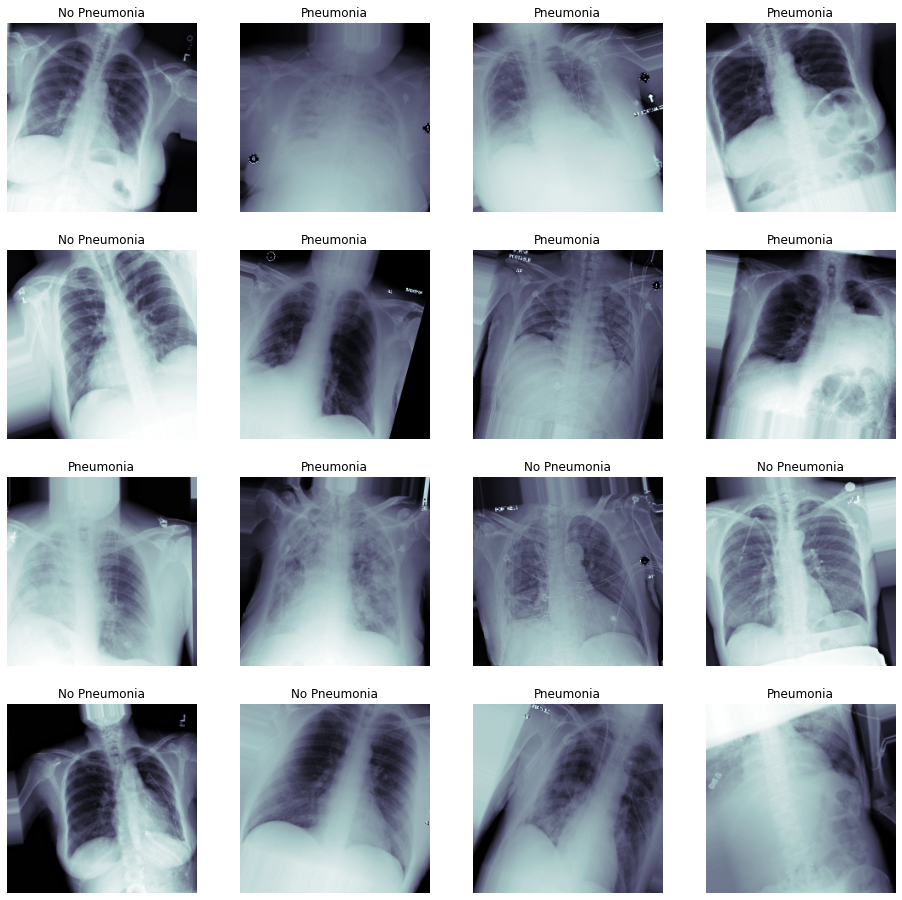

In [31]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning



In [32]:
# We'll load in VGG16 with pre-trained ImageNet weights:
def load_pretrained_model():
    # Define the model we will use
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model
vgg_model = load_pretrained_model()
vgg_model.summary()


553467904/553467096 [==============================] - 7s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [33]:
def build_my_model(vgg_model):
    # Todo
    ## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
    ## Here, we'll freeze all but the last convolutional layer
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        print(layer.name, layer.trainable)
    
    
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1000, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(500, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    return my_model

my_model = build_my_model(vgg_model)
my_model.summary()

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              25089000  
_________________________________________________________________
drop

### Epoch
The traing data will be fed over my CNN overe and over again whilst it tries to learn the important features of my data. 

Each time my entire traing data set is passed through the CNN, we call this one epoch.

At each epoch, we may decide to apply augmentation to some of our traiaing images, so that our CNN doesn't see quite the same images every single time.

### Loss Function
At the end of each epoch CNN has something called a. loss function to calcul;ate how different its prediction is from the ground truth of the training image. We can call this difference, the training loss.

If the loss is small, it means the CNN did well in classifying the training images that it saw in our epoch.

The network, then uses training loss to go back and update the **weights** of every single filter in the layers we want to train.

This technique is called **backpropagation**. It updates weight in a way that makes weights more accurate more accurate in the next epoch.

Once these weights are updated, the training data is processed again in a second epoch and the process repeats.

Choosing how may epochs to train for is very important because training as many epcoh as possible not always useful

Note
We also use that loss function to evaluate the loss on our held-out validation set. That is we calculate a validation loss that measures how the prediction validation data. Same here, a smaller loss indicates that the CNN did well classifying a validation image, except for at this step, we don't update our weights.

The validation set is just a test of performance of our model, not teaching it how to be better. 


In [34]:
## Set our learning rate, loss and accuracy function
optimizer = Adam(lr=5e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [35]:
# Call my model compile API for the learning rate and metrics
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [36]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo
weight_path="{}_my_model.best.hdf5".format('pneumonia_class')

checkpoint = ModelCheckpoint(weight_path, 
                            monitor= 'val_loss', 
                            verbose=1, 
                            save_best_only=True, 
                            # Repeat these epoch until we reach a min loss
                            mode= 'min', 
                            save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min',
                       # Meaning that my_model will train for 5 epochs without seeing improvement before quitting
                       patience=10)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=0, 
                              verbose=1, 
                              mode='min')

hist = CSVLogger('history.csv')


callbacks_list = [checkpoint, early, lr_reduce, hist]

### Start training! 

In [37]:
## train your model
# Todo

# Note the train_gen, the new variable is the new data in this case

# Records of loss and epoch in both the training data and validation data are saved here
# during the traiang of the model. 

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 20, 
                           callbacks = callbacks_list)


Epoch 1/20
144/144 [==============================] - 1559s 11s/step - loss: 0.8739 - binary_accuracy: 0.5227 - val_loss: 0.6499 - val_binary_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 0.64990, saving model to pneumonia_class_my_model.best.hdf5
Epoch 2/20
144/144 [==============================] - 1541s 11s/step - loss: 0.8410 - binary_accuracy: 0.5122 - val_loss: 0.7146 - val_binary_accuracy: 0.4688

Epoch 00002: val_loss did not improve from 0.64990

Epoch 00002: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Epoch 3/20
144/144 [==============================] - 1536s 11s/step - loss: 0.8033 - binary_accuracy: 0.5166 - val_loss: 0.6753 - val_binary_accuracy: 0.4688

Epoch 00003: val_loss did not improve from 0.64990

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
Epoch 4/20
144/144 [==============================] - 1528s 11s/step - loss: 0.7875 - binary_accuracy: 0.5122 - val_loss: 0.6781 - val_binary_accuracy: 0

In [38]:
# list all data in history
pd.DataFrame(history.history).to_csv("history.csv")
# plot_data = pd.read_csv('history.csv')

## Training
Meaning determing good values for all weights and bias from labeled examples.

Loss is the penalty for a bad prediction. Loss is a number that indicating how bad the model's prediction was on a single example. If the model prediction is perfect, the loss is zero, otherwise the loss is greater.

### A single hyperparameter model training
It utilises a negative descent technique :On a loss v value of weight, a negative descent means geting a decrease loss value with a change in a single parameter such as learning rate. The starting lr was 4.

The direction of travel is dependent on what happens to loss value with increasing or decreasing the learning rate.

In this case, If I increase learning rate, the loss increased which is not a negative descent. In the next circle, I dereased the learning rate and that lead to a decreased loss consistent with negative descent.

I continued to deccreae the learning rate until loss gets to zero and stop. If however, increasing the learning rate had led to a negative loss(negative descent), then I would have gone on increasing learning rate until I get to loss of zero.


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [99]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 100, verbose = True)

100/100 [==============================] - 59s 592ms/step


In [100]:
# val_gen is being used here to pull validation data for performance evaluation
val_gen = val_idg.flow_from_dataframe(dataframe=val_data, 
                                 directory=None, 
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE, 
                                 batch_size = 100) ## We've only been provided with 6 validation images




Found 1430 validated image filenames belonging to 2 classes.


In [101]:
## May want to pull a single large batch of random validation data for testing after each epoch:
# calling val_gen.next() returns two variables: valX and valY
valX, valY = val_gen.next()
prediction = pred_Y.reshape(-1) # This is the result of the prediction
label= valY.reshape(-1)  # These are the labels we are trying to predict


In [102]:
# Create a dataframe with these variables
performances = pd.DataFrame({'ground_truth': label, 'probability': prediction})
performances.head()


,ground_truth,probability
0,1.0,0.380571
1,0.0,0.412602
2,0.0,0.434989
3,0.0,0.441659
4,0.0,0.382594


### How to create complex columns
Best resource on how to use **Apply** and **Lambda** in pandas [here](https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7)

In [103]:
#Create a method that takes in a variable label and returns a str(normal) or str(abnormal) in place of label for Pneumonia or Not Pneumonia

def ground_truth(Pneumonia):
    if Pneumonia > 0:
        return 'abnormal'
    else:
        return 'normal'
# Create a new column algorithm_output and populate it with the value of ground_truth classified as normal
# The values for the column pneumonia_class should be of string datatype

all_xray_df['ground_truth'] = all_xray_df.apply(lambda x: ground_truth(x['Pneumonia']), axis=1)
#all_xray_df.sample(3)





In [104]:
# Create a new column that is th sum of all concurrent diseases with pneumonia sum of all the columns
all_xray_df['comorbidity'] = all_xray_df['Atelectasis'] + all_xray_df['Effusion'] + all_xray_df['Pneumothorax'] + all_xray_df['Infiltration'] + all_xray_df['Cardiomegaly'] + all_xray_df['Mass'] + all_xray_df['Nodule'] 

all_xray_df.to_csv('comorbidity.csv')





### Comorbidity distribution
This block of code will give you the total count for each disease that occur with Pneumonia, you can see the result of this code by printing the value of variable "diseases_freq".


In [105]:
demographics = pd.DataFrame(all_xray_df[['comorbidity', 'Patient Age', 'Patient Gender', 'View Position', 'ground_truth']]).to_csv('demographics.csv')




### Explanation of valY and pred_Y

Th meaning of the pred_y) & (val_y), please find my answer below:

valY(t_y): is the single batch that comes from the validation data set. It is considered to be the actual true labels of the data (images) that had been passed to our model. Therefore each value in valY is our label in the validation dataset.

pred_y(p_y): is a single batch of the prediction model for our data and each value corresponds to the actual true labels (valY).

The plots acc, pre_roc and F1 score are all dealing with both values (val_Y , Pred_Y). The difference between the true values in Val_Y and what has been prediction in (Pred_Y).


### Function arguments
The value of t_y should be a single batch of validation data which in your case is "valY" derived from ```valX, valY = val_gen.next()```.

The value of pred_Y should be a single batch of predicted data which in my case is "pred_Y", derived from the code:
```
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)
```

In [106]:
# My history
hist

In [107]:
# function to plot the roc_curve. You can utilize roc_curve and auc imported above
def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    # calculate the fpr and tpr for all thresholds of the classification with imported libaries
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    # precision recall, have to have values in the form of either 0 or 1 (i.e) your target classes
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

    
# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

   
def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()
    return

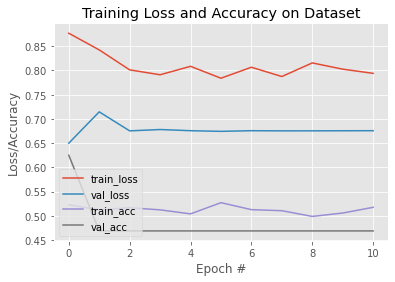

In [108]:
## plot figures

# Todo

plot_history(history)

The model is converging and this can be observed from the decrease loss and validation loss with epochs. It reached 50% validation accuracy in just 1 epoch.

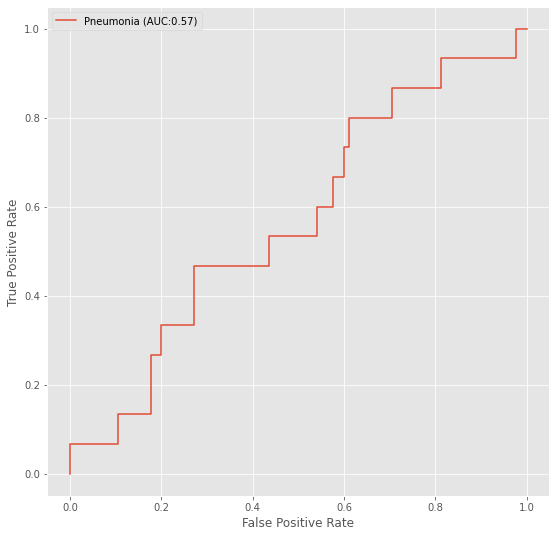

In [109]:
# fpr, tpr, threshold = plot_auc(valY, pred_Y)
plot_roc_curve(performances['ground_truth'], performances['probability'])

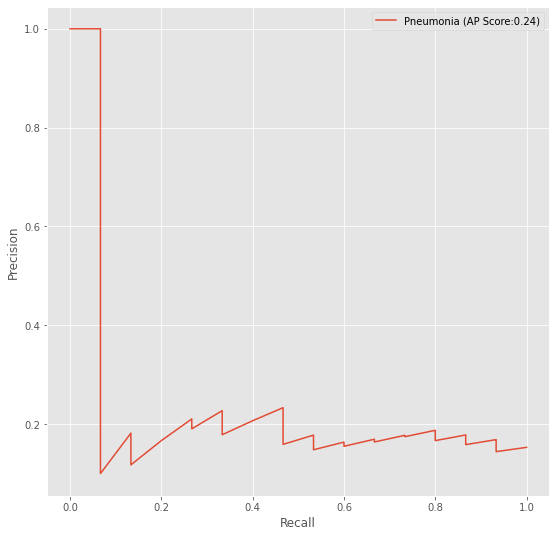

In [110]:
# plot precision v recall
plot_precision_recall_curve(performances['ground_truth'], performances['probability'])

In [111]:
# Call precision_recall_curve()
precision, recall, thresholds = precision_recall_curve(performances['ground_truth'], performances['probability'])


In [112]:
pd.DataFrame({'recall': recall[:-1], 'precision': precision[:-1], 'thresholds': thresholds}).head()


,recall,precision,thresholds
0,1.000000,0.153061,0.348572
1,0.933333,0.144330,0.352430
2,0.933333,0.145833,0.353719
3,0.933333,0.147368,0.353841
4,0.933333,0.148936,0.354538


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

## Accuracy(error rate)
[Accuracy](https://deepai.org/machine-learning-glossary-and-terms/accuracy-error-rate) is the number of correctly predicted data points out of all the data points. It is defined as the number of true positives and true negatives divided by the number of true positives, true negatives, false positives, and false negatives. Not good for rare disea

### Examine the _accuracy_ under the two scenarios
Now look at what the _accuracy_ of our model would be using those two threshold values. **Hint, you can add a new column with value 0 or 1 as predictions based on the threshold you choose, then you can calculate accuracy using ground truth and the prediction you just made.**

Print the _accuracy_ in both the cases, and think about why accuracy really isn't a great performance statistic when evaluating and interpreting the utility of our models. 

In [113]:
probs = performances['probability']
# Thresholds 1 and 2
t1 = (probs > 0.79)
t2 = (probs > 0.39)

**As we can see, the thresholds are really different for the two cases.**

In [114]:
t1 = t1.replace(True,1).replace(False,0)
t2 = t2.replace(True,1).replace(False,0)

In [115]:
# Look for matches between t1 and ground_truth
compare_t1 = (t1 == performances['ground_truth'])
# Look for matches between t2 and ground_truth
compare_t2 = (t2 == performances['ground_truth'])

In [116]:
print('Accuracy at threshold 1: ' + str(len(compare_t1[compare_t1])/len(performances)))

Accuracy at threshold 1: 0.85


In [117]:
print('Accuracy at threshold 2: ' + str(len(compare_t2[compare_t2])/len(performances)))

Accuracy at threshold 2: 0.34


### Beyond accuracy
Details of article [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

#### Visualizing Precision and Recall

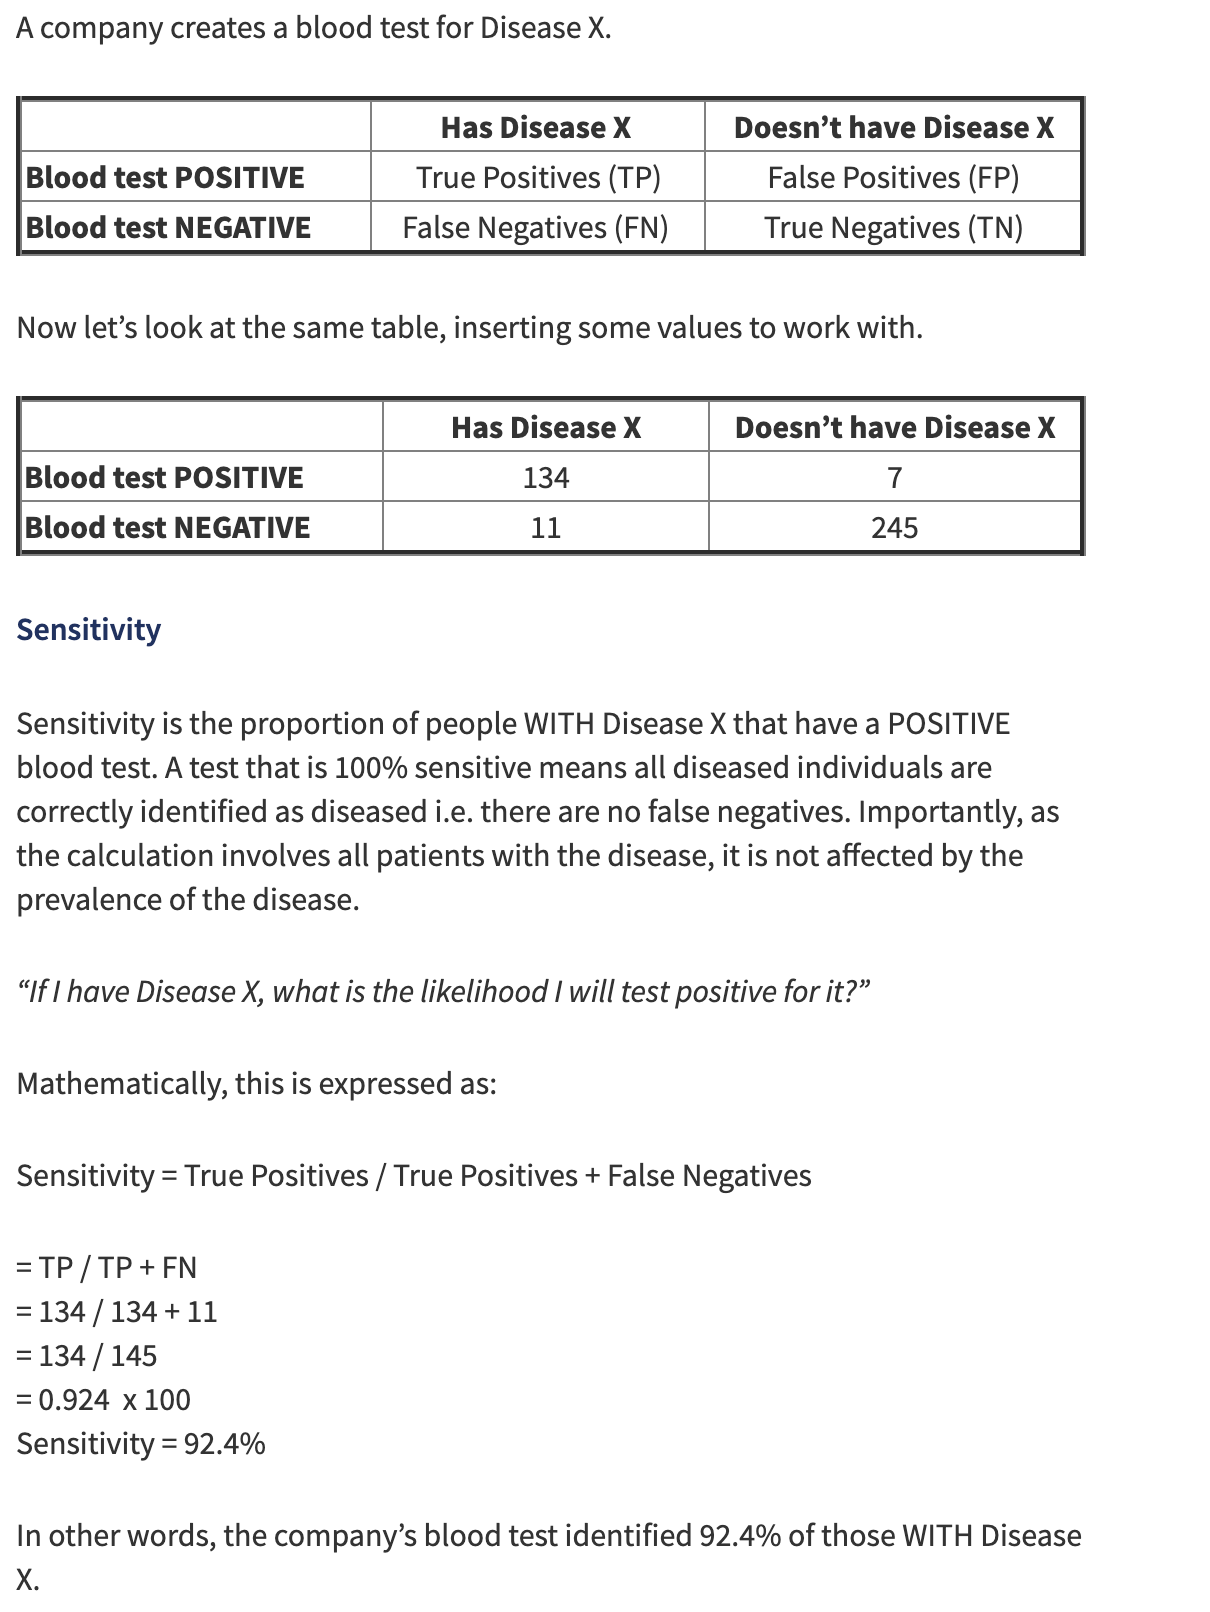




### Precision
For precision, you look at the number of positive cases accurately identified by the algorithm divided by all of the cases identified as positive by the algorithm.  

Precision TP/(TP + FP)

Regardless of whether they are identified right or wrong. The other name for precision is positive predictive value.

Precision is a great metric when we care most about positive results ie finding disease. 

### Recall
Recall on the other hand allows us to rule out diseases. 

When a test with high recall returns a negative result, you can be pretty confident that the result is truely negative. Recall does not take into account FP though, so you may still be labelling alot of negative cases as positive. So recall are good for screening tests.  Recall has another name - Sensitivity


Recall TP/(TP + FN)


Optimising one of these metrics usually comes at the expense of sacrifcing the other.


### Calculate F1 Score
F1 Score does not take TN into account since it is not in the equation for precision or recall


Calculate F1 score for two different scenarios here, 
1. Choose a threshold that favors precision, 
2. Choose a threshold that favors recall

Print the precision, recall, threshold, and F1 score for each scenario.



In [118]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# The prevalence of pneumonia is too small to reliably use precision

# Look at the threshold where precision is 0.8
precision_value = 0.8
# argmin function return indices of minimum values

#THESE TWO LINES IN THE CODE IS TO CORRECT THE ERROR BELWO
precision = precision[:-1]
recall = recall[:-1]

idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 1.0
Recall is: 0.06666666666666667
Threshold is: 0.60581666
F1 Score is: 0.125


In [119]:
# Look at the threshold where recall is 0.8
# For our model, we are more interested in identifying all cases of pneumonia, 
# therefore, we would way our threshold towards recall.

recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.16666666666666666
Recall is: 0.8
Threshold is: 0.40128386
F1 Score is: 0.27586206896551724


In [121]:
best_threshold = 0.40
YOUR_THRESHOLD = best_threshold

### Create algorithm output column
Firstly to create the output column you can use the following piece of code:-

In the for loop here, I use 1430. This is the number of Pneumonia cases in our dataset therefore the number of outputs will be 1430.


Now that we have our output stored in the list named "ans" we will assign it to the data frame by using:

In [122]:
test_idg = ImageDataGenerator(rescale=1. / 255.0)
test_gen = test_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 1)
testX, testY = test_gen.next()
ans = [0]*1430
for i in range(1430):
    if my_model.predict(testX, batch_size = 1430, verbose = True) > YOUR_THRESHOLD:
        ans[i] = 1

Found 1430 validated image filenames belonging to 2 classes.
1/1 [==============================] - 1s 526ms/step


In [123]:
val_data['algorithm_output'] = ans
val_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,algorithm_output
1927,00000499_008.png,Pneumonia,8,499,34,F,PA,2052,2271,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1
3416,00000910_001.png,Atelectasis|Pneumonia,1,910,56,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1
86153,00021243_001.png,Pneumonia,1,21243,28,M,PA,2588,2824,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1
8420,00002235_001.png,Atelectasis|Pneumonia,1,2235,53,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1
102517,00027320_013.png,Effusion|Infiltration|Pneumonia,13,27320,52,M,PA,2992,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1


### TP and TN
True positive and True negatives data point are the observations that are correctly predicted. The goal is to minimize **false postives** and **false negatives**

## FP and FN
The FP and FN negative data points the obervations that are incorrectly predicted. 
In False positives, people without x disease have been predicted as positive for disease x by the device.

In False negative, people with disease x have beed predicted as negative for disease x by the device.

If the algorithm classified a normal data point as abnormal, it would be a false positive.

Details of the article [here](https://uk.cochrane.org/news/sensitivity-and-specificity-explained-cochrane-uk-trainees-blog)

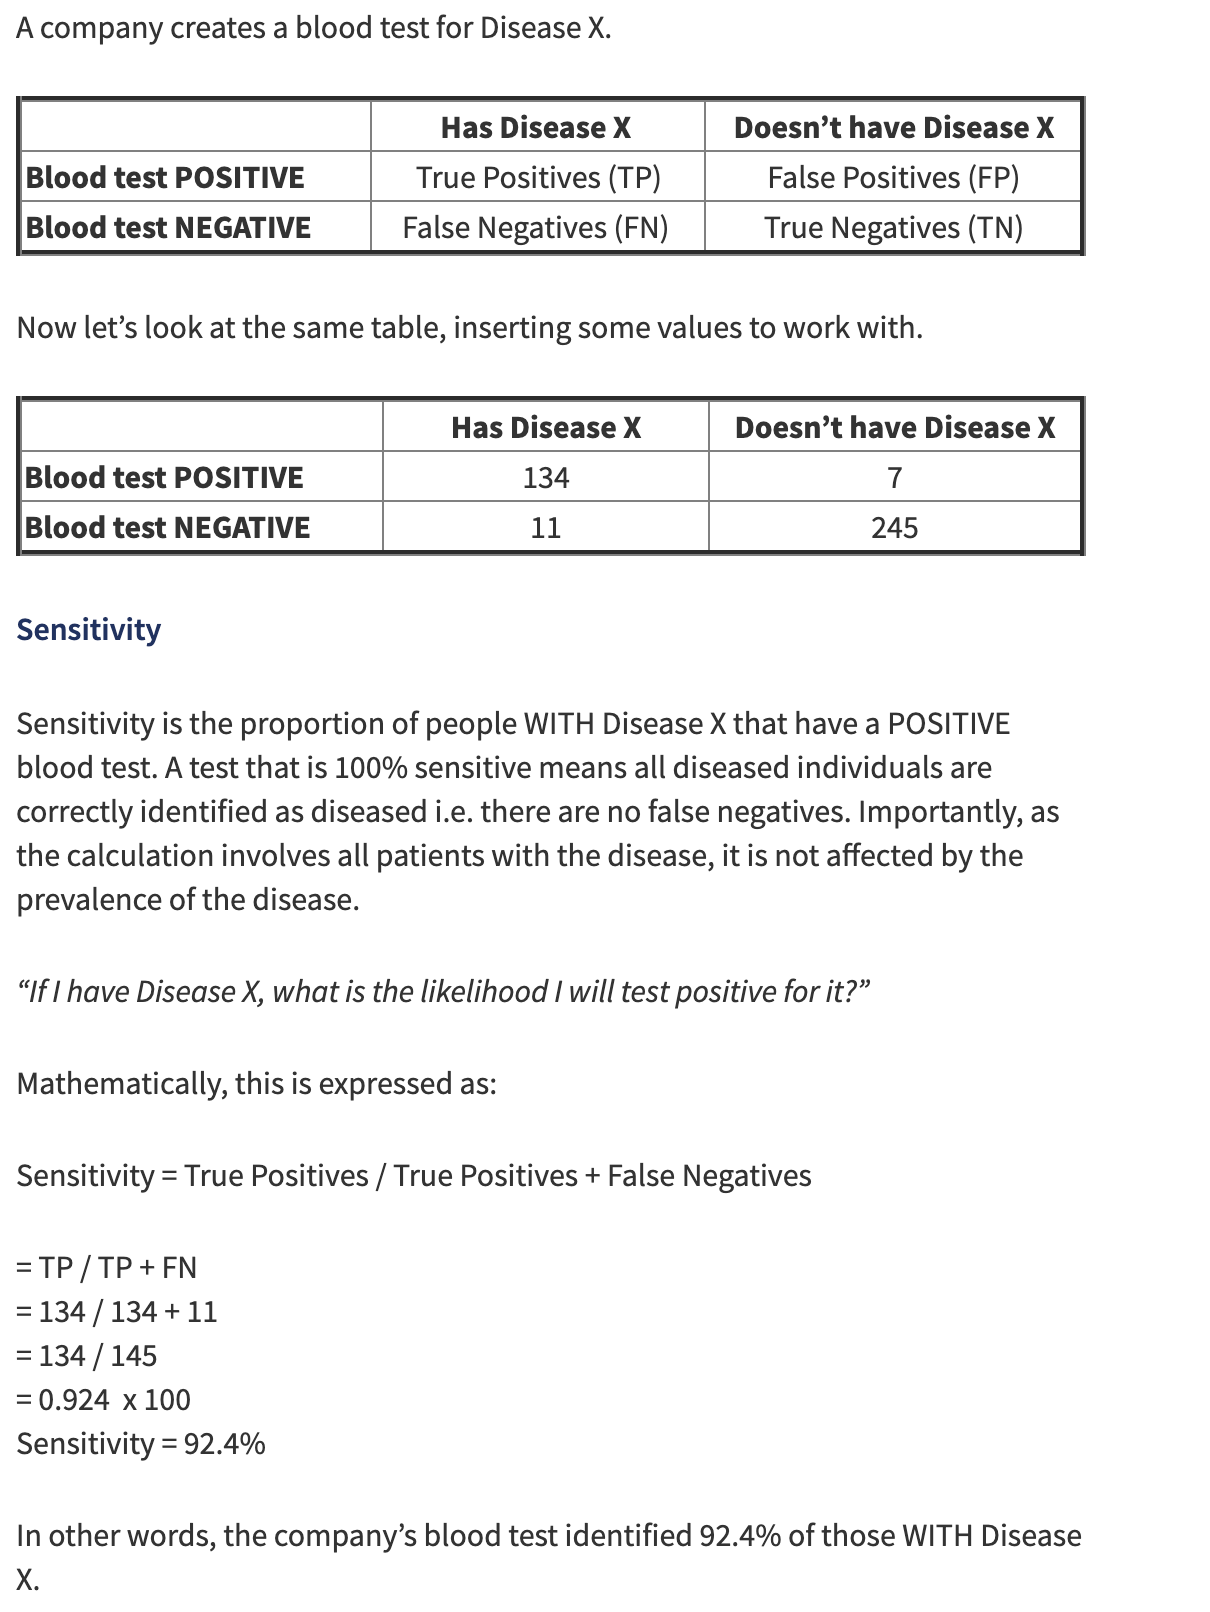




### Sensitivity and  specificity

Great resource [here](https://uk.cochrane.org/news/sensitivity-and-specificity-explained-cochrane-uk-trainees-blog)

Sensitivity is the ratio of correctly predicted positive observations to the total of all positives cases in the dataset(which includes both TP and FN). Therefore, total predicted includes the **FP numbers** TP/TP + FN


Sensitivity has two other names: **recall** and **True positive rate**. Recall is very important because we care more about finding positive cases than we care about negative cases. Recall tells us how often we find positive cases. But it says nothing about negative cases.

**specificity**
Specificity is the ratio of correctly predicted negative observations to the total of all negative cases in the dataset(which includes both TN and FP). The specificity of a clinical test refers to the
ability of the test to correctly identify those
patients without the disease.

Specificity TN/(TN + FP)



**First, look at the overall performance of the algorithm for the detection of pneumonia:**

In [124]:
import sklearn.metrics
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(val_data.Pneumonia.values,
                                                  val_data.algorithm_output.values,labels=[0,1]).ravel()


In [125]:
sens = tp/(tp+fn)
sens

1.0

In [126]:
spec = tn/(tn+fp)
spec

0.0

Now, look at the algorithm's performance in the presence of the other diseases: 


In [127]:
for i in ['Atelectasis','Effusion','Pneumothorax','Infiltration','Cardiomegaly','Mass','Nodule']:
    

    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(val_data[val_data[i]==1].Pneumonia.values,
                                                  val_data[val_data[i]==1].algorithm_output.values,labels=[0,1]).ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)

    print(i)
    print('Sensitivity: '+ str(sens))
    print('Specificity: ' +str(spec))

Atelectasis
Sensitivity: 1.0
Specificity: 0.0
Effusion
Sensitivity: 1.0
Specificity: 0.0
Pneumothorax
Sensitivity: 1.0
Specificity: 0.0
Infiltration
Sensitivity: 1.0
Specificity: 0.0
Cardiomegaly
Sensitivity: 1.0
Specificity: 0.0
Mass
Sensitivity: 1.0
Specificity: 0.0
Nodule
Sensitivity: 1.0
Specificity: 0.0


### How to create complex columns
**Apply and Lambda usage in pandas**

For literature on how [Click here](https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7)

Define a function that will take the column values I want to play with to come up with my logic.


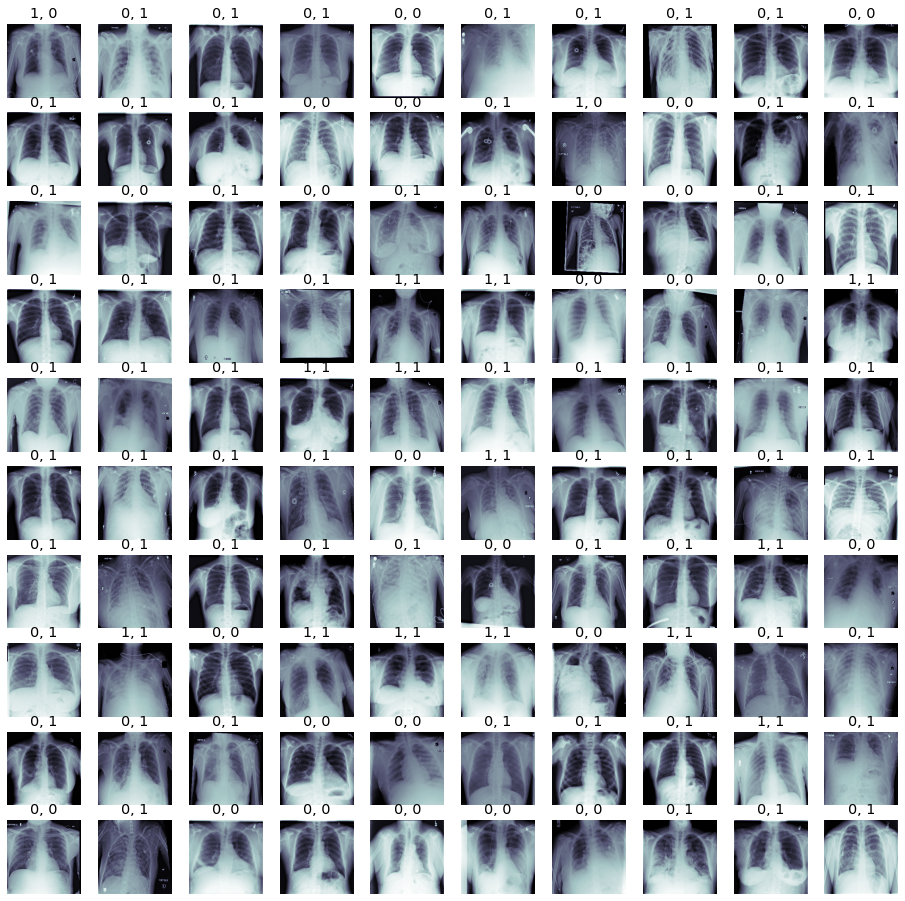

In [131]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
best_threshold = 0.40
YOUR_THRESHOLD = best_threshold
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [132]:
# Create a new column with algorithm out put
pd.DataFrame(val_data).to_csv('performances.csv')

In [133]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)